### Monitoring of the water extent of Lake Neusiedl and the Lacken:
#### Train and Evaluation

In [1]:
# del sys.modules['data_func']
import sys
# del sys.modules['model']


In [2]:
import torch
import copy
from data_func import merge_files_and_split, ImageDataset, make_list, visualize_augmentations
from model import DownSample,DoubleConv,OutConv,UpSample,UNet
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from torch import optim, nn
import cv2
import time
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torch.optim import Adam
from torch import permute
from torch import nan_to_num
from torch.nn import BCEWithLogitsLoss
from torchvision.transforms import ToTensor
import rasterio
from torch import nn
from torch import optim, nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
import os
from torch.nn import functional as F
os.environ["NO_ALBUMENTATIONS_UPDATE"] = "1"
import albumentations as A

from torch.cuda.amp import autocast, GradScaler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt

/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# pip install tqdm

In [4]:
# pip install torchvision

### Data Preparation & Augmentation

In [5]:
train_batch_size = 4
val_batch_size = 4
test_batch_size = 4

In [6]:

# train_transform = A.Compose(
#     [
#         A.Resize(256, 256),
#         A.VerticalFlip(p=0.5),
#         A.HorizontalFlip(p=0.5),
#         A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
#         A.Normalize(
#             mean=[0.485, 0.456, 0.406],
#             std=[0.229, 0.224, 0.225]),
#         # ToTensorV2()
#     ])


train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
    A.RandomResizedCrop(256, 256, scale=(0.8, 1.0), p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
run_colab = False
if run_colab:
    train_set = ImageDataset('./drive/MyDrive/IntProject/train/', './drive/MyDrive/IntProject/train_mask', train_transform)
    trainloader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True,num_workers=2)
    val_set = ImageDataset('./drive/MyDrive/IntProject/val/', './drive/MyDrive/IntProject/val_mask', train_transform)
    valloader = torch.utils.data.DataLoader(val_set, batch_size=val_batch_size, shuffle=True,num_workers=2)
    test_set = ImageDataset('./drive/MyDrive/IntProject/test/', './drive/MyDrive/IntProject/test_mask', None)
    testloader = torch.utils.data.DataLoader(val_set, batch_size=test_batch_size, shuffle=True,num_workers=2)
else:
    train_set = ImageDataset('./train/', './train_mask', train_transform)
    trainloader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True,num_workers=2)
    val_set = ImageDataset('./val/', './val_mask', train_transform)
    valloader = torch.utils.data.DataLoader(val_set, batch_size=val_batch_size, shuffle=True,num_workers=2)
    test_set = ImageDataset('./test/', './test_mask', None)
    testloader = torch.utils.data.DataLoader(val_set, batch_size=test_batch_size, shuffle=True,num_workers=2)

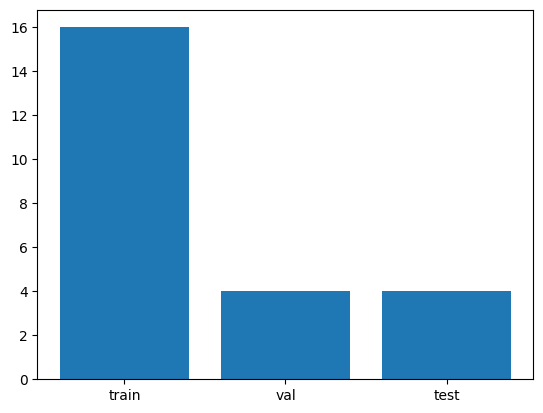

In [8]:
dataset_sizes = [len(train_set), len(val_set), len(test_set)]
labels = ['train', 'val', 'test']

plt.bar(labels, dataset_sizes)
plt.show()

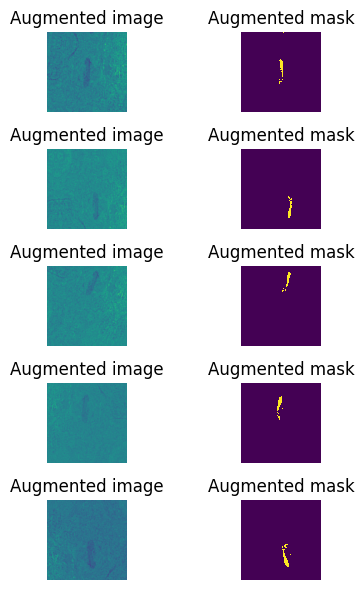

In [9]:
visualize_augmentations(train_set, idx=1, samples=5)


#### Train & Evaluate

In [10]:
class DiceBCELoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceBCELoss,self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        intersection = 2*(logits * targets).sum() + self.smooth
        union = (logits + targets).sum() + self.smooth
        dice_loss = 1. - intersection / union

        loss = nn.BCELoss()
        bce_loss = loss(logits, targets)

        return dice_loss + bce_loss
    
def dice_coeff(logits, targets):
    intersection = 2*(logits * targets).sum()
    union = (logits + targets).sum()
    if union == 0:
        return 1
    dice_coeff = intersection / union
    return dice_coeff.item()

def iou(logits, targets):
    intersection = (logits * targets).sum()
    union = (logits + targets).sum() - intersection
    iou = intersection / union
    return iou.item()

def pixel_accuracy(logits, targets):
    logits = (logits > 0.5).float()
    
    # Ensure targets are also binary
    targets = targets.float()
    tp = (logits == targets).sum()
    total = logits.numel()
    accuracy = tp / total
    return accuracy.item()
    

In [11]:
def train(model, trainloader, optimizer, loss, epochs=10):
    train_losses, val_losses = [], []
    train_dices, val_dices = [], []
    train_ious, val_ious = [], []
    train_accs, val_accs = [], []
    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss = 0
        train_dice = 0
        train_iou = 0
        train_acc = 0
        for i, (images, masks) in enumerate(trainloader):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            logits = model(images)
            l = loss(logits, masks)
            l.backward()
            optimizer.step()
            train_loss += l.item()
            train_dice += dice_coeff(logits, masks)
            train_iou += iou(logits, masks)
            train_acc += pixel_accuracy(logits, masks)
        train_loss /= len(trainloader)
        train_dice /= len(trainloader)
        train_iou /= len(trainloader)
        train_losses.append(train_loss)
        train_dices.append(train_dice)
        train_ious.append(train_iou)
        train_accs.append(train_acc)
        
        #Validation
        model.eval()
        val_loss = 0
        val_dice = 0
        val_iou = 0
        val_acc = 0
        with torch.no_grad():
            for i, (images, masks) in enumerate(valloader):
                images, masks = images.to(device), masks.to(device)
                logits = model(images)
                l = loss(logits, masks)
                val_loss += l.item()
                val_dice += dice_coeff(logits, masks)
                val_iou += iou(logits, masks)
                val_acc += pixel_accuracy(logits, masks)
        val_loss /= len(valloader)
        val_dice /= len(valloader)
        val_iou /= len(valloader)
        val_acc /= len(valloader)
        val_losses.append(val_loss)
        val_dices.append(val_dice)
        val_ious.append(val_iou)
        val_accs.append(val_acc)
        print(f"Epoch: {epoch + 1}  Train Loss: {train_loss:.4f} | Train DICE Coeff: {train_dice:.4f}  | Train IoU Coeff: {train_iou:.4f}|  | Train Accuracy: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val DICE Coeff: {val_dice:.4f} | Val IoU Coeff: {val_iou:.4f}| Val Accuracy: {val_acc:.4f}| ")
        
    return train_losses, train_dices, val_losses, val_dices

In [14]:
epochs = 50
loss = DiceBCELoss()
model = UNet(1, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses, train_dices, val_losses, val_dices = train(model, trainloader, optimizer, loss, epochs)

  2%|▏         | 1/50 [00:44<35:58, 44.06s/it]

Epoch: 1  Train Loss: 1.5441 | Train DICE Coeff: 0.0161  | Train IoU Coeff: 0.0081|  | Train Accuracy: 3.3606 | Val Loss: 1.7443 | Val DICE Coeff: 0.0151 | Val IoU Coeff: 0.0076| Val Accuracy: 0.0076| 


  4%|▍         | 2/50 [01:28<35:14, 44.04s/it]

Epoch: 2  Train Loss: 1.3732 | Train DICE Coeff: 0.0183  | Train IoU Coeff: 0.0092|  | Train Accuracy: 3.9309 | Val Loss: 1.7352 | Val DICE Coeff: 0.0148 | Val IoU Coeff: 0.0074| Val Accuracy: 0.0153| 


  6%|▌         | 3/50 [02:13<34:56, 44.60s/it]

Epoch: 3  Train Loss: 1.3088 | Train DICE Coeff: 0.0200  | Train IoU Coeff: 0.0101|  | Train Accuracy: 3.9542 | Val Loss: 1.6824 | Val DICE Coeff: 0.0159 | Val IoU Coeff: 0.0080| Val Accuracy: 0.4846| 


  8%|▊         | 4/50 [02:57<33:56, 44.28s/it]

Epoch: 4  Train Loss: 1.2658 | Train DICE Coeff: 0.0234  | Train IoU Coeff: 0.0119|  | Train Accuracy: 3.9756 | Val Loss: 1.8523 | Val DICE Coeff: 0.0192 | Val IoU Coeff: 0.0097| Val Accuracy: 0.0416| 


  8%|▊         | 4/50 [03:23<39:04, 50.96s/it]


KeyboardInterrupt: 